# T027 · Kinase similarity: Ligand profile

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Talia B. Kimber, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Andrea Volkamer, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

The aim of this talktorial is to investigate kinase similarity through ligand profiling data (ChEMBL29). In the context of drug design, the following assumption is often made: if a compound was tested active on two different kinases, it is suspected that these two kinases may have some degree of similarity. We will use this assumption in this talktorial. The concept of kinase promiscuity is also covered.

### Contents in *Theory*

* Kinase dataset
* Bioactivity data
* Kinase similarity descriptor: Ligand profile
    * Kinase similarity
    * Kinase promiscuity
* From similarity matrix to distance matrix

### Contents in *Practical*

* Define the kinases of interest
* Retrieve the data
* Preprocess the data
    * Hit or non-hit
* Kinase promiscuity
* Kinase similarity
    * Visualize similarity as kinase matrix
    * Save kinase similarity matrix
* Kinase distance matrix
    * Save kinase distance matrix

### References

* Kinase dataset: [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629) 
* ChEMBL database
  * Website: https://www.ebi.ac.uk/chembl/
  * Paper: [<i>Nucleic Acid Research</i> (2017), <b>45(D1)</b>, D945-D954](https://doi.org/10.1093/nar/gkw1074) 
* KinMap
  * Website: http://www.kinhub.org/kinmap/
  * Paper: [<i>BMC Bioinformatics</i> (2017), <b>18(1)</b>, 16](https://doi.org/10.1186/s12859-016-1433-7) 

## Theory

### Kinase dataset

We use the kinase selection as defined in __Talktorial T023__.

### Bioactivity data

In order to measure kinase similarity through ligand profiling data, bioactivity data is retrieved from the well-known [ChEMBL](https://www.ebi.ac.uk/chembl/) database and the query focuses on human kinases. Luckily, a curated version of ChEMBL29 is already freely available through the Openkinome organization, see https://github.com/openkinome/kinodata.
For more details on querying the ChEMBL database, please refer to __Talktorial T001__.

In drug design, it is common to binarize the activity of a compound against a target of interest as a "hit" or "non-hit". Practically speaking, this is done using a cutoff value for measured activity. If the activity is greater than the cutoff, the compound is labeled as active (hit), and inactive (non-hit) otherwise.

![Manning tree with number of ChEMBL activities per kinase (KinMap)](images/kinmap_n_activities_per_kinase.png)


*Figure 1:* 
Number of ChEMBL29 bioactivities per kinase - as collected in [kinodata](https://github.com/openkinome/kinodata) - mapped onto the Manning kinome tree using [KinMap](http://www.kinhub.org/kinmap/). The figure has been generated in __Talktorial T023__.

### Kinase similarity descriptor: Ligand profile

As a measure of similarity, we use ligand profiling data in this talktorial.

#### Kinase similarity

We use the following metric as similarity between two kinases $K_i$ and $K_j$ :

$$
\text{similarity}(K_i, K_j) = \frac{\#\text{ of compounds that were tested active on both } K_i \text{ and } K_j}
{\#\text{ of compounds that were tested on both } K_i \text{ and } K_j}.
$$

Assuming that only one compound was tested on two kinases, and that the compound was tested as active for one and inactive for the other, then the similarity between these two kinases would be zero.

#### Kinase promiscuity
Computing the similarity between a kinase and itself may be interpreted as kinase promiscuity, where the similarity described above would therefore represent the fraction of active compounds over all tested compounds.

### From similarity matrix to distance matrix

As discussed in __Talktorial T024__, we convert the similarity matrix to a distance matrix.

## Practical

In [1]:
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [3]:
configs = pd.read_csv(HERE / "../T023_what_is_a_kinase/data/pipeline_configs.csv")
configs = configs.set_index("variable")["default_value"]
DEMO = bool(int(configs["DEMO"]))
print(f"Run in demo mode: {DEMO}")
# NBVAL_CHECK_OUTPUT

Run in demo mode: True


### Define the kinases of interest

Let's load the kinase selection as defined in __Talktorial T023__.

In [4]:
kinase_selection_df = pd.read_csv(
    HERE
    / "../T023_what_is_a_kinase/\
data/kinase_selection.csv"
)
kinase_selection_df
# NBVAL_CHECK_OUTPUT

,kinase,kinase_klifs,uniprot_id,group,full_kinase_name
0,EGFR,EGFR,P00533,TK,Epidermal growth factor receptor
1,ErbB2,ErbB2,P04626,TK,Erythroblastic leukemia viral oncogene homolog 2
2,PI3K,p110a,P42336,Atypical,Phosphatidylinositol-3-kinase
3,VEGFR2,KDR,P35968,TK,Vascular endothelial growth factor receptor 2
4,BRAF,BRAF,P15056,TKL,Rapidly accelerated fibrosarcoma isoform B
5,CDK2,CDK2,P24941,CMGC,Cyclic-dependent kinase 2
6,LCK,LCK,P06239,TK,Lymphocyte-specific protein tyrosine kinase
7,MET,MET,P08581,TK,Mesenchymal-epithelial transition factor
8,p38a,p38a,Q16539,CMGC,p38 mitogen activated protein kinase alpha


### Retrieve the data

We retrieve a pre-curated version of a kinase subset of ChEMBL29 freely available at Openkinome, see https://github.com/openkinome/kinodata/releases/tag/v0.3.

In [5]:
path = "https://github.com/openkinome/kinodata/releases/download/\
v0.3/activities-chembl29_v0.3.zip"
# Load data and reset index so that it starts from 0
data = pd.read_csv(path, index_col=0).reset_index(drop=True)
print(f"Current shape of data: {data.shape}")
data.head()
# NBVAL_CHECK_OUTPUT

Current shape of data: (190634, 16)


,activities.activity_id,assays.chembl_id,target_dictionary.chembl_id,molecule_dictionary.chembl_id,molecule_dictionary.max_phase,activities.standard_type,activities.standard_value,activities.standard_units,compound_structures.canonical_smiles,compound_structures.standard_inchi,component_sequences.sequence,assays.confidence_score,docs.chembl_id,docs.year,docs.authors,UniprotID
0,16291323,CHEMBL3705523,CHEMBL2973,CHEMBL3666724,0,pIC50,14.096910,nM,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,InChI=1S/C31H33N7O3/c1-2-4-29(40)33-22-6-3-5-2...,MSRPPPTGKMPGAPETAPGDGAGASRQRKLEALIRDPRSPINVESL...,9,CHEMBL3639077,2014.0,NaN,O75116
1,16264754,CHEMBL3705523,CHEMBL2973,CHEMBL3666728,0,pIC50,14.000000,nM,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,InChI=1S/C34H40N8O3/c1-5-7-32(43)36-24-9-6-8-2...,MSRPPPTGKMPGAPETAPGDGAGASRQRKLEALIRDPRSPINVESL...,9,CHEMBL3639077,2014.0,NaN,O75116
2,16306943,CHEMBL3705523,CHEMBL2973,CHEMBL1968705,0,pIC50,14.000000,nM,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,InChI=1S/C31H33N7O2/c1-2-6-29(39)33-23-8-5-7-2...,MSRPPPTGKMPGAPETAPGDGAGASRQRKLEALIRDPRSPINVESL...,9,CHEMBL3639077,2014.0,NaN,O75116
3,16340050,CHEMBL3705523,CHEMBL2973,CHEMBL1997433,0,pIC50,13.958607,nM,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,InChI=1S/C28H28N6O3/c1-3-5-26(35)30-20-7-4-6-1...,MSRPPPTGKMPGAPETAPGDGAGASRQRKLEALIRDPRSPINVESL...,9,CHEMBL3639077,2014.0,NaN,O75116
4,16287186,CHEMBL3705523,CHEMBL2973,CHEMBL3666721,0,pIC50,13.920819,nM,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,InChI=1S/C32H35N7O2/c1-2-7-30(40)34-24-9-6-8-2...,MSRPPPTGKMPGAPETAPGDGAGASRQRKLEALIRDPRSPINVESL...,9,CHEMBL3639077,2014.0,NaN,O75116


### Preprocess the data

We look at the type of activity and the associated units.

In [6]:
print(
    f"Activities: {sorted(set(data['activities.standard_type']))}\n"
    f"Units: {set(data['activities.standard_units'])}"
)

Activities: ['pIC50', 'pKd', 'pKi']
Units: {'nM'}


Let's keep the entries which have pIC50 values only.

In [7]:
data = data[data["activities.standard_type"] == "pIC50"]

In [8]:
data.columns
# NBVAL_CHECK_OUTPUT

Index(['activities.activity_id', 'assays.chembl_id',
       'target_dictionary.chembl_id', 'molecule_dictionary.chembl_id',
       'molecule_dictionary.max_phase', 'activities.standard_type',
       'activities.standard_value', 'activities.standard_units',
       'compound_structures.canonical_smiles',
       'compound_structures.standard_inchi', 'component_sequences.sequence',
       'assays.confidence_score', 'docs.chembl_id', 'docs.year',
       'docs.authors', 'UniprotID'],
      dtype='object')

The DataFrame contains many columns that won't be necessary for the rest of the notebook which are therefore removed. 
Only relevant information is kept, namely the canonical SMILES of the compound (`compound_structures.canonical_smiles`), the measured activity (`activities.standard_value`) and the UniProt ID of the kinase (`UniprotID`). These columns are renamed for readability.

In [9]:
data = data[["compound_structures.canonical_smiles", "activities.standard_value", "UniprotID"]]
data = data.rename(
    columns={
        "compound_structures.canonical_smiles": "smiles",
        "activities.standard_value": "pIC50",
    }
)

In [10]:
print(f"Current shape of data: {data.shape}")
data.head()
# NBVAL_CHECK_OUTPUT

Current shape of data: (160857, 3)


,smiles,pIC50,UniprotID
0,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,14.096910,O75116
1,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,14.000000,O75116
2,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,14.000000,O75116
3,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,13.958607,O75116
4,CCCC(=O)Nc1cccc(-c2nc(Nc3ccc4[nH]ncc4c3)c3cc(O...,13.920819,O75116


NA values are dropped.

In [11]:
data = data.dropna()
print(f"Current shape of data: {data.shape}")
# NBVAL_CHECK_OUTPUT

Current shape of data: (160703, 3)


We only keep the data for the query kinases:

In [12]:
data = data[data["UniprotID"].isin(kinase_selection_df["uniprot_id"])]
print(f"Current shape of data: {data.shape}")
data.head()
# NBVAL_CHECK_OUTPUT

Current shape of data: (33427, 3)


,smiles,pIC50,UniprotID
58,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,P00533
98,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,P00533
99,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,P00533
140,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,P00533
141,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,P00533


Let's look at example data (which corresponds to the first row in the kinase selection DataFrame):

In [13]:
example_kinase = kinase_selection_df["kinase_klifs"][0]
example_uniprot = kinase_selection_df["uniprot_id"][0]

example_data = data[data["UniprotID"] == example_uniprot]

print(f"Example kinase: {example_kinase}")

Example kinase: EGFR


Some compounds have been tested several times against a target, as shown below.

In [14]:
measured_compounds = Counter(example_data["smiles"])
try:
    top_measured_compounds = measured_compounds.most_common()[0:5]
except IndexError:
    top_measured_compounds = measured_compounds.most_common()
top_measured_compounds
# NBVAL_CHECK_OUTPUT

[('COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1', 39),
 ('C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1', 27),
 ('C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(OC)cc1N(C)CCN(C)C', 15),
 ('C=CC(=O)Nc1cccc(Oc2nc(Nc3ccc(N4CCN(C)CC4)cc3OC)ncc2Cl)c1', 11),
 ('CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)o1', 8)]

We have a look at those compounds.

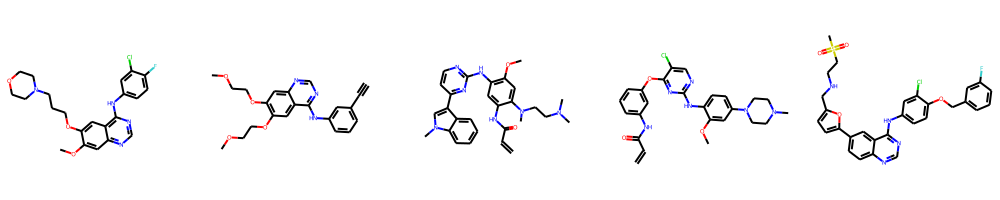

In [15]:
mols = []
for entry in top_measured_compounds:
    mols.append(Chem.MolFromSmiles(entry[0]))
Draw.MolsToGridImage(mols, molsPerRow=5)

In this example (demo mode), the first molecule is gefitinib, a known FDA-approved drug against EGFR.

As a simple workaround — since we prefer to have one activity value per compound-kinase pair — we keep the value for which the compound has the best activity value, i.e., the highest pIC50 value.

In [16]:
data = data.groupby(["UniprotID", "smiles"])["pIC50"].max().reset_index()
data.head()
# NBVAL_CHECK_OUTPUT

,UniprotID,smiles,pIC50
0,P00533,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1ccc(C(...,5.336488
1,P00533,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1cccc2c...,5.996539
2,P00533,Br.CC[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1...,8.397940
3,P00533,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,7.207608
4,P00533,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,8.420216


#### Hit or non-hit

Finally, we binarize the pIC50 values to obtain hit or non-hit using a cutoff. We use a pIC50 cutoff of $6.3$, similarly to the cutoff used in [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629).

In [17]:
cutoff = 6.3

In [18]:
def binarize_pic50(pic50_value, threshold):
    """
    Binarizes a scalar value given a threshold.

    Parameters
    ----------
    pic50_value : float
        The measurement pIC50 value of a kinase-ligand pair.
    threshold : float
        The cutoff to determine activity.

    Returns
    -------
    int
        1 if the pIC50 value is above the threshold, which indicates activity.
        0 otherwise.
    """
    if pic50_value >= threshold:
        return 1
    else:
        return 0

In [19]:
data["activity_binary"] = data["pIC50"].apply(binarize_pic50, args=(cutoff,))

In [20]:
print(f"Current shape of data: {data.shape}")
data.head()
# NBVAL_CHECK_OUTPUT

Current shape of data: (32916, 4)


,UniprotID,smiles,pIC50,activity_binary
0,P00533,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1ccc(C(...,5.336488,0
1,P00533,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1cccc2c...,5.996539,0
2,P00533,Br.CC[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1...,8.397940,1
3,P00533,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,7.207608,1
4,P00533,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,8.420216,1


### Kinase promiscuity

We now look at the kinase promiscuity.

For a given kinase, three values are computed:

1. the total number of measured compounds against the given kinase,
2. the number of active compounds against the kinase, and
3. the fraction of active compounds, i.e., the ratio of active compounds over the total number of measured compounds per kinase.

In [21]:
def kinase_to_activity_numbers(uniprot_id, activity_df):
    """
    Retrieve the three values for a given kinase.

    Parameters
    ----------
    uniprot_id : str
        The UniProt ID of the kinase of interest, e.g. "P00533" for "EGFR".
    activity_df : pd.DataFrame
        The dataframe with activity values for kinases.

    Returns
    -------
    tuple : (int, int, float)
        The three metrics:
        1. The total number of measured compounds against the kinase.
        2. The number of active compounds against the kinase.
        3. The fraction of active compounds against the kinase.
    """
    kinase_data = activity_df[activity_df["UniprotID"] == uniprot_id]
    total_measured_compounds = len(kinase_data)
    active_compounds = len(kinase_data[kinase_data["activity_binary"] == 1])
    if total_measured_compounds > 0:
        fraction = active_compounds / total_measured_compounds
    else:
        print("No compounds were measured for this kinase.")
        fraction = np.nan
    return (total_measured_compounds, active_compounds, fraction)

Let's see what information we get for the first kinase in our dataset:

In [22]:
example_kinase = kinase_selection_df["kinase_klifs"][0]
example_uniprot = kinase_selection_df["uniprot_id"][0]

print(f"{example_kinase} ({example_uniprot}):")
example_metrics = kinase_to_activity_numbers(example_uniprot, data)
print(
    f"{'Total number of measured compounds:' : <40}"
    f"{example_metrics[0]} \n"
    f"{'Number of active compounds:' : <40}"
    f"{example_metrics[1]} \n"
    f"{'Fraction of active compounds:' : <40}"
    f"{example_metrics[2]:.2f} \n"
)
# NBVAL_CHECK_OUTPUT

EGFR (P00533):
Total number of measured compounds:     5965 
Number of active compounds:             3635 
Fraction of active compounds:           0.61 



Let's create a table from these values for all kinases:

In [23]:
def promiscuity_table(kinase_selection, activity_df):
    """
    Create a table with all three values for all kinases.

    Parameters
    ----------
    kinase_selection : pd.DataFrame
        The DataFrame for the chosen kinases.
    activity_df : pd.DataFrame
        The DataFrame with activity values for kinases.

    Returns
    -------
    promiscuity_table : pd.DataFrame
        A DataFrame with the kinases as rows and values as columns.
    """
    promiscuity_table = pd.DataFrame(
        index=kinase_selection["kinase_klifs"], columns=["total", "actives", "fraction"]
    )
    promiscuity_table.index.name = None
    promiscuity_table.columns.name = None

    for name, uniprot_id in zip(kinase_selection["kinase_klifs"], kinase_selection["uniprot_id"]):
        values = kinase_to_activity_numbers(uniprot_id, activity_df)
        promiscuity_table.loc[name] = values
    return promiscuity_table

In [24]:
kinase_promiscuity_df = promiscuity_table(kinase_selection_df, data)
kinase_promiscuity_df
# NBVAL_CHECK_OUTPUT

,total,actives,fraction
EGFR,5965,3635,0.609388
ErbB2,1700,1031,0.606471
p110a,4393,2827,0.643524
KDR,7641,5328,0.697291
BRAF,3688,2992,0.81128
CDK2,1500,815,0.543333
LCK,1560,935,0.599359
MET,2832,2248,0.793785
p38a,3637,2778,0.763816


Let's beautify the table:

In [24]:
kinase_promiscuity_df.style.format("{:.3f}", subset=["fraction"]).background_gradient(
    cmap="Purples", subset=["fraction"]
).highlight_min(color="yellow", axis=None, subset=["fraction"]).highlight_max(
    color="red", subset=["fraction"]
)

,total,actives,fraction
EGFR,5965,3635,0.609
ErbB2,1700,1031,0.606
p110a,4393,2827,0.644
KDR,7641,5328,0.697
BRAF,3688,2992,0.811
CDK2,1500,815,0.543
LCK,1560,935,0.599
MET,2832,2248,0.794
p38a,3637,2778,0.764


From the table, we notice that CDK2 is the least (in yellow) and BRAF the most (in red) promiscuous kinase.

### Kinase similarity

We now investigate how we can use the similarity measure discussed in the _Theory_ part to compare kinases. 

In [26]:
def similarity_ligand_profile(uniprot_id1, uniprot_id2, activity_df):
    """
    Compute the similarity between two kinases using ligand profiling data.

    Parameters
    ----------
    uniprot_id1 : str
        UniProt ID of first kinase of interest.
    uniprot_id2 : str
        UniProt ID of second kinase of interest.
    activity_df :  pd.DataFrame
        The DataFrame with activity values for kinases.

    Returns
    -------
    tuple : (int, int, float)
        The three metrics:
        1. The total number of measured compounds against both kinases.
        2. The number of active compounds against both kinases.
        3. The metric for kinase similarity,
                i.e. number of active compounds on both kinases
                over number of measured compounds on both kinases.
    """
    if uniprot_id1 == uniprot_id2:
        return kinase_to_activity_numbers(uniprot_id1, activity_df)
    else:
        # Data for the two kinases only
        reduced_data = activity_df[activity_df["UniprotID"].isin([uniprot_id1, uniprot_id2])]

        # Look at active compounds only
        active_entries = reduced_data[reduced_data["activity_binary"] == 1]
        # Group by compounds
        compounds = active_entries.groupby("smiles").size()
        # Look at the number of active compounds measured on both kinases
        active_compounds_on_both = compounds[compounds == 2].shape[0]

        # Look at all tested compounds
        compounds = reduced_data.groupby("smiles").size()
        # Look at the number of compounds measured on both kinases
        measured_compounds_on_both = compounds[compounds == 2].shape[0]

        if measured_compounds_on_both > 0:
            fraction = active_compounds_on_both / measured_compounds_on_both
        else:
            print(
                f"No compounds were measured on both kinases, "
                f"namely {uniprot_id1} and {uniprot_id2}."
            )
            fraction = np.nan
            measured_compounds_on_both = np.nan
            active_compounds_on_both = np.nan
        return (measured_compounds_on_both, active_compounds_on_both, fraction)

Let's look at the values and similarity between two kinases.

In [27]:
if DEMO:
    kinase1 = "EGFR"
    uniprot1 = "P00533"
    kinase2 = "MET"
    uniprot2 = "P08581"
else:
    kinase1 = kinase_selection_df["kinase_klifs"][0]
    uniprot1 = kinase_selection_df["uniprot_id"][0]
    kinase2 = kinase_selection_df["kinase_klifs"][1]
    uniprot2 = kinase_selection_df["uniprot_id"][1]

similarity_example = similarity_ligand_profile(uniprot1, uniprot2, data)
print(
    f"Values for {kinase1} and {kinase2}: \n\n"
    f"{'Total number of measured compounds:' : <50}"
    f"{similarity_example[0]} \n"
    f"{'Number of active compounds:' : <50}"
    f"{similarity_example[1]} \n"
    f"Fraction of active compounds or \n"
    f"{'ligand profile similarity:' : <50}"
    f"{similarity_example[2]:.2f} \n"
)
# NBVAL_CHECK_OUTPUT

Values for EGFR and MET: 

Total number of measured compounds:               92 
Number of active compounds:                       21 
Fraction of active compounds or 
ligand profile similarity:                        0.23 



#### Visualize similarity as kinase matrix

Let's first look at the non-reduced fraction of number of active compound against total number of compounds to have an idea of the counts.

In [28]:
kinase_counts_matrix = pd.DataFrame(
    index=kinase_selection_df.kinase_klifs, columns=kinase_selection_df.kinase_klifs
)
kinase_counts_matrix.index.name = None
kinase_counts_matrix.columns.name = None

for i, (uniprot_id1, klifs_name1) in enumerate(
    zip(kinase_selection_df.uniprot_id, kinase_selection_df.kinase_klifs)
):
    for j, (uniprot_id2, klifs_name2) in enumerate(
        zip(kinase_selection_df.uniprot_id, kinase_selection_df.kinase_klifs)
    ):
        total, actives, _ = similarity_ligand_profile(uniprot_id1, uniprot_id2, data)
        integer_ratio = f"{actives}/{total}"
        kinase_counts_matrix[klifs_name1][klifs_name2] = integer_ratio
kinase_counts_matrix
# NBVAL_CHECK_OUTPUT

No compounds were measured on both kinases, namely P04626 and P42336.
No compounds were measured on both kinases, namely P42336 and P04626.


,EGFR,ErbB2,p110a,KDR,BRAF,CDK2,LCK,MET,p38a
EGFR,3635/5965,662/1170,13/179,313/893,27/59,5/40,31/126,21/92,18/52
ErbB2,662/1170,1031/1700,nan/nan,72/180,4/16,4/27,5/33,1/28,2/16
p110a,13/179,nan/nan,2827/4393,32/174,1/3,4/12,0/3,0/1,0/5
KDR,313/893,72/180,32/174,5328/7641,199/262,71/115,179/413,184/340,63/122
BRAF,27/59,4/16,1/3,199/262,2992/3688,1/13,22/40,3/26,29/41
CDK2,5/40,4/27,4/12,71/115,1/13,815/1500,2/18,2/22,1/9
LCK,31/126,5/33,0/3,179/413,22/40,2/18,935/1560,17/63,69/138
MET,21/92,1/28,0/1,184/340,3/26,2/22,17/63,2248/2832,1/20
p38a,18/52,2/16,0/5,63/122,29/41,1/9,69/138,1/20,2778/3637


Note that the total number of tested compounds as well as the number of active compounds on two kinases vary largely.

* For the p110a-ErbB2 pair, there are none.
* For p110a and [BRAF, CDK2, LCK, MET and p38a], there are less than $13$ commonly tested compounds.
* In contrast, the EGFR-ErbB2 pair has $1170$ commonly tested compounds, of which $662$ were active on both.

Now let's look at the similarity, in this case, the reduced fraction:

In [29]:
kinase_similarity_matrix = np.zeros((len(kinase_selection_df), len(kinase_selection_df)))
for i, uniprot_id1 in enumerate(kinase_selection_df.uniprot_id):
    for j, uniprot_id2 in enumerate(kinase_selection_df.uniprot_id):
        kinase_similarity_matrix[i, j] = similarity_ligand_profile(uniprot_id1, uniprot_id2, data)[
            2
        ]

No compounds were measured on both kinases, namely P04626 and P42336.
No compounds were measured on both kinases, namely P42336 and P04626.


In [30]:
kinase_similarity_matrix_df = pd.DataFrame(
    data=kinase_similarity_matrix,
    index=kinase_selection_df.kinase_klifs,
    columns=kinase_selection_df.kinase_klifs,
)
kinase_similarity_matrix_df.index.name = None
kinase_similarity_matrix_df.columns.name = None
kinase_similarity_matrix_df
# NBVAL_CHECK_OUTPUT

,EGFR,ErbB2,p110a,KDR,BRAF,CDK2,LCK,MET,p38a
EGFR,0.609388,0.565812,0.072626,0.350504,0.457627,0.125000,0.246032,0.228261,0.346154
ErbB2,0.565812,0.606471,NaN,0.400000,0.250000,0.148148,0.151515,0.035714,0.125000
p110a,0.072626,NaN,0.643524,0.183908,0.333333,0.333333,0.000000,0.000000,0.000000
KDR,0.350504,0.400000,0.183908,0.697291,0.759542,0.617391,0.433414,0.541176,0.516393
BRAF,0.457627,0.250000,0.333333,0.759542,0.811280,0.076923,0.550000,0.115385,0.707317
CDK2,0.125000,0.148148,0.333333,0.617391,0.076923,0.543333,0.111111,0.090909,0.111111
LCK,0.246032,0.151515,0.000000,0.433414,0.550000,0.111111,0.599359,0.269841,0.500000
MET,0.228261,0.035714,0.000000,0.541176,0.115385,0.090909,0.269841,0.793785,0.050000
p38a,0.346154,0.125000,0.000000,0.516393,0.707317,0.111111,0.500000,0.050000,0.763816


In [31]:
# Show matrix with background gradient
cm = sns.light_palette("green", as_cmap=True)
kinase_similarity_matrix_df.style.background_gradient(cmap=cm).format("{:.3f}")

,EGFR,ErbB2,p110a,KDR,BRAF,CDK2,LCK,MET,p38a
EGFR,0.609,0.566,0.073,0.351,0.458,0.125,0.246,0.228,0.346
ErbB2,0.566,0.606,nan,0.400,0.250,0.148,0.152,0.036,0.125
p110a,0.073,nan,0.644,0.184,0.333,0.333,0.000,0.000,0.000
KDR,0.351,0.400,0.184,0.697,0.760,0.617,0.433,0.541,0.516
BRAF,0.458,0.250,0.333,0.760,0.811,0.077,0.550,0.115,0.707
CDK2,0.125,0.148,0.333,0.617,0.077,0.543,0.111,0.091,0.111
LCK,0.246,0.152,0.000,0.433,0.550,0.111,0.599,0.270,0.500
MET,0.228,0.036,0.000,0.541,0.115,0.091,0.270,0.794,0.050
p38a,0.346,0.125,0.000,0.516,0.707,0.111,0.500,0.050,0.764


Note that the diagonal contains the previously discussed promiscuity values.

As mentioned above, no compounds were measured on both ErbB2 and p110a and therefore creates a `np.nan` entry which can be problematic for algorithmic reason.

As a simple workaround, we will fill the NA values with zero.

In [32]:
kinase_similarity_matrix_df = kinase_similarity_matrix_df.fillna(0)

kinase_similarity_matrix_df.style.background_gradient(cmap=cm).format("{:.3f}")

,EGFR,ErbB2,p110a,KDR,BRAF,CDK2,LCK,MET,p38a
EGFR,0.609,0.566,0.073,0.351,0.458,0.125,0.246,0.228,0.346
ErbB2,0.566,0.606,0.000,0.400,0.250,0.148,0.152,0.036,0.125
p110a,0.073,0.000,0.644,0.184,0.333,0.333,0.000,0.000,0.000
KDR,0.351,0.400,0.184,0.697,0.760,0.617,0.433,0.541,0.516
BRAF,0.458,0.250,0.333,0.760,0.811,0.077,0.550,0.115,0.707
CDK2,0.125,0.148,0.333,0.617,0.077,0.543,0.111,0.091,0.111
LCK,0.246,0.152,0.000,0.433,0.550,0.111,0.599,0.270,0.500
MET,0.228,0.036,0.000,0.541,0.115,0.091,0.270,0.794,0.050
p38a,0.346,0.125,0.000,0.516,0.707,0.111,0.500,0.050,0.764


#### Save kinase similarity matrix

In [33]:
kinase_similarity_matrix_df.to_csv(DATA / "kinase_similarity_matrix.csv")

### Kinase distance matrix

The similarity matrix $SM$ is converted to a pseudo-distance matrix (all entries of the similarity matrix are between $0$ and $1$):

In [34]:
print(
    f"The values of the similarity matrix lie between: "
    f"{kinase_similarity_matrix_df.min().min():.2f}"
    f" and {kinase_similarity_matrix_df.max().max():.2f}"
)
# NBVAL_CHECK_OUTPUT

The values of the similarity matrix lie between: 0.00 and 0.81


In [35]:
kinase_distance_matrix_df = 1 - kinase_similarity_matrix_df

Finally, we set the diagonal values to $0$ and we obtain the kinase distance matrix:

In [36]:
np.fill_diagonal(kinase_distance_matrix_df.values, 0)

In [37]:
kinase_distance_matrix_df.style.background_gradient(cmap=cm).format("{:.3f}")

,EGFR,ErbB2,p110a,KDR,BRAF,CDK2,LCK,MET,p38a
EGFR,0.000,0.434,0.927,0.649,0.542,0.875,0.754,0.772,0.654
ErbB2,0.434,0.000,1.000,0.600,0.750,0.852,0.848,0.964,0.875
p110a,0.927,1.000,0.000,0.816,0.667,0.667,1.000,1.000,1.000
KDR,0.649,0.600,0.816,0.000,0.240,0.383,0.567,0.459,0.484
BRAF,0.542,0.750,0.667,0.240,0.000,0.923,0.450,0.885,0.293
CDK2,0.875,0.852,0.667,0.383,0.923,0.000,0.889,0.909,0.889
LCK,0.754,0.848,1.000,0.567,0.450,0.889,0.000,0.730,0.500
MET,0.772,0.964,1.000,0.459,0.885,0.909,0.730,0.000,0.950
p38a,0.654,0.875,1.000,0.484,0.293,0.889,0.500,0.950,0.000


#### Save kinase distance matrix

In [38]:
kinase_distance_matrix_df.to_csv(DATA / "kinase_distance_matrix.csv")

## Discussion

In this talktorial, we investigate how activity data can be used as a measure of similarity between kinases. The fraction of compounds tested as actives over the total number of measured compounds is a way of accessing the similarity. Moreover, using the same rationale, the promiscuity of a kinase can be quantified using the ratio of active compounds over measured compounds.

When working with these data, we have to keep in mind that some kinases have much higher coverage with respect to the number of compounds that were tested against them, leading to an imbalance in information content.
This cannot be inferred from the calculated fraction. For example, the pairs EGFR-KDR and EGFR-p38a both have a profile similarity of $0.35$. However, the first was calculated based on $893$ tested compounds, whereas the latter on $52$ only.

The kinase distance matrix above will be reloaded in __Talktorial T028__, where we compare kinase similarities from different perspectives, including the ligand profile perspective we have talked about in this talktorial.

## Quiz

1. Is there an optimal way to deal with multiple kinase-ligand measurements?
2. Can promiscuity be fairly compared between two kinases if one has been tested against many compounds whereas the other only against very few? 
3. Using the similarity described in this talktorial, what does it mean that two kinases have a similarity of $0$, as is the case for p110a and LCK?